In [1]:
import numpy as np
import os
import yaml
from pprint import pprint
from lomentum.loader import read_element
from lomentum.plotting import plotter
from lomentum.loader import register_user_module
from qdev_wrappers.pulse_building import atoms_ext 
from qcodes.instrument.base import InstrumentBase
from qdev_wrappers.station_configurator import StationConfigurator
from qdev_wrappers.customised_instruments.interfaces.microwave_source_interface import SimulatedMicrowaveSourceInterface, SGS100AMicrowaveSourceInterface
from qdev_wrappers.customised_instruments.interfaces.AWG_interface import SimulatedAWGInterface, AWG5014Interface
from qdev_wrappers.customised_instruments.composite_instruments.parametric_sequencer.parametric_sequencer import ParametricSequencer
from qdev_wrappers.customised_instruments.composite_instruments.multiplexer.multiplexer import Multiplexer
register_user_module(atoms_ext)

/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/logger.py:16: UserWarning: The logger.py of qdev-wrappers is deprecated and will be removed soon. Please use the logger of QCoDeS instead.
  warnings.warn('The logger.py of qdev-wrappers is deprecated and will be '
/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/station_configurator.py:21: UserWarning: ruamel yaml not found station configurator is falling back to pyyaml. It's highly recommended to install ruamel.yaml. This fixes issues with scientific notation and duplicate instruments in the YAML file
  warnings.warn("ruamel yaml not found station configurator is falling back to pyyaml. "


In [2]:
def print_params(instr):
    print('\n')
    print(instr.name.upper())
    for k, v in instr.parameters.items():
        if k != 'IDN':
            print(k, ': ', v())
    for k, v in instr.submodules.items():
        if isinstance(v, InstrumentBase):
            print_params(v)

## Now for some advanced stuff
 
Lets imagine we want to use one microwave source (or heterodyne source) and two awg channels to create multiple sidebands (we'll go with 2 to keep things simple)... Let's go ahead and set these up 

In [3]:
with open('multiqubit_sidebanding_element.yaml') as f:
    yf = yaml.safe_load(f)
    template_element = read_element(yf)

In [4]:
real_instruments_present = False

In [5]:
if real_instruments_present:
    sc = StationConfigurator()
    awg = sc.load_instrument('AWG5014')
    microwave_source = sc.load_instrument('SGS100A')
    awg_if = AWG5014Interface('awg', awg)
    carrier_if = SGS100AMicrowaveSourceInterface('source')
else:
    awg_if = SimulatedAWGInterface('awg')
    carrier_if = SimulatedMicrowaveSourceInterface('source')
awg_if.to_default()
carrier_if.to_default()
ps = ParametricSequencer('ps', awg_if)

Now we need to create two sidebanders, the multiplexer has a handy function for doing that. Checking out what happens and what the defaults are. Note that the sidebanders are given names which are just the multiplexer name plus their index. It should also be noted that these names are prepended to the symbol names so the symbols for pulse building will now be distinguishable between sidebanders (check out the multiqubit_sidebanding_element.yaml file for clarification).

In [6]:
multiplexer = Multiplexer('R', ps, carrier_if)
sidebander0 = multiplexer.add_sidebander()
sidebander1 = multiplexer.add_sidebander()

uploading
running


/Users/natalie/Documents/PhD/Qdev/lomentum/lomentum/plotting.py:252: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=800.0, top=800.0
  ax.set_ylim([ymin-0.05*yrange, ymax+0.2*yrange])
/Users/natalie/Documents/PhD/Qdev/lomentum/lomentum/plotting.py:252: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim([ymin-0.05*yrange, ymax+0.2*yrange])
/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/customised_instruments/composite_instruments/sidebander/sidebander.py:17: UserWarning: Carrier status is off
  warn('Carrier status is off')
/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/customised_instruments/composite_instruments/sidebander/sidebander.py:20: UserWarning: Sidebander carrier IQ state is off
  warn('Sidebander carrier IQ state is off')


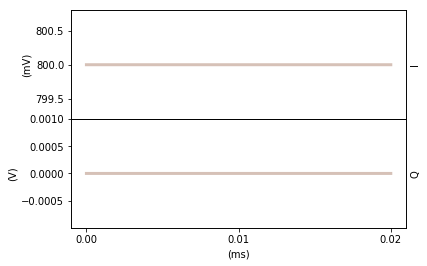

In [7]:
multiplexer.change_sequence(template_element=template_element)

setting sequence_mode to element
setting element to 0
running
setting repetition_mode to inf
running


R
carrier_power :  -10
carrier_frequency :  6000000000.0
carrier_status :  1


R0
frequency :  6000000000.0
carrier_frequency :  6000000000.0
sideband_frequency :  0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.8
status :  1


R1
frequency :  6000000000.0
carrier_frequency :  6000000000.0
sideband_frequency :  0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.8
status :  1


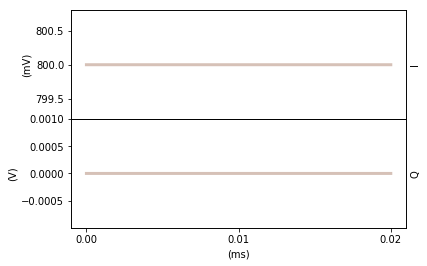

In [8]:
multiplexer.to_default()
print_params(multiplexer)

Now setting up some sideband frequencies. This can be done by accessing the individual sidebanders as in the Sidebander example notebook or by accessing properties via the multiplexer. Again the single_upload context manager is available.

uploading
setting element to 0
running


R
carrier_power :  -10
carrier_frequency :  6000000000.0
carrier_status :  1


R0
frequency :  6001000000.0
carrier_frequency :  6000000000.0
sideband_frequency :  1000000.0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.8
status :  1


R1
frequency :  6000200000.0
carrier_frequency :  6000000000.0
sideband_frequency :  200000.0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.8
status :  1


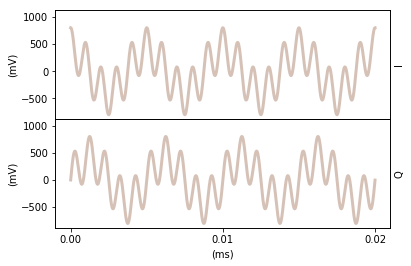

In [9]:
with multiplexer.single_upload():
    multiplexer.R0.sideband_frequency(1e6)
    multiplexer.R1.sideband_frequency(0.2e6)
print_params(multiplexer)

As before I can save time by uploading a sequence and going between it's elements. On changing if possible the parameter values are preserved but if they are no longer part of the sequence then the user is warned and they are updated.

uploading
setting element to 0
running
setting element to 4
running


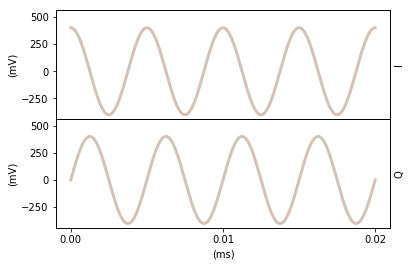

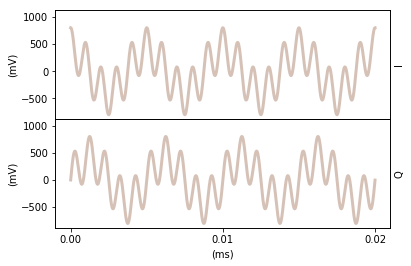

In [10]:
multiplexer.change_sequence(inner_setpoints=('R0_amplitude', np.arange(5) * 0.2))

setting element to 0
running


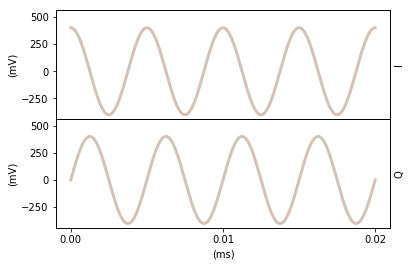

In [11]:
multiplexer.R0.amplitude(0)

uploading
setting element to 0
running
0.3


/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/customised_instruments/composite_instruments/sidebander/sidebander.py:124: UserWarning: Parameter R0_amplitude could not be synced, value is now 0.3
  '{}'.format(setpoints.symbol, sequencer_param()))


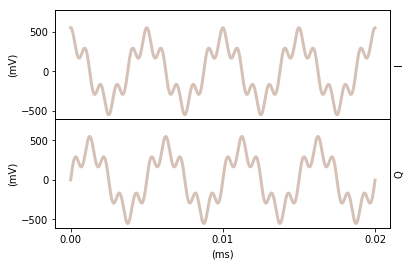

In [12]:
multiplexer.change_sequence(inner_setpoints=('R0_amplitude', np.arange(2) * 0.2 + 0.3))
print(multiplexer.R0.amplitude())

I am no longer allowed to change the carrier_frequency on the sidebanders (as the resultant frequency for both sidebanders depends on it) but I can do so for the multiplexer and it correspondingly updates the sidebanders.

In [13]:
try:
    sidebander0.carrier_frequency(5e6)
except Exception as e:
    print(e)

('Parmeter carrier_frequency not settable', 'setting R0_carrier_frequency to 5000000.0')


In [14]:
multiplexer.carrier_frequency(6.001e9)
print_params(multiplexer)



R
carrier_power :  -10
carrier_frequency :  6001000000.0
carrier_status :  1


R0
frequency :  6002000000.0
carrier_frequency :  6001000000.0
sideband_frequency :  1000000.0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.3
status :  1


R1
frequency :  6001200000.0
carrier_frequency :  6001000000.0
sideband_frequency :  200000.0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.8
status :  1
